In [1]:
import sys
import os
from pathlib import Path
project_dir = Path(os.path.abspath('')).parent
sys.path.insert(0, project_dir.as_posix())

from tqdm import trange, tqdm
import numpy as np
import torch
from matplotlib import  pyplot as plt
from cs336_basics.nn_336 import TransformerLM
from cs336_basics.train import AdamW, cross_entropy, save_checkpoint, load_checkpoint, load_data, get_lr_cosine_schedule, gradient_clipping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [2]:
tokens = np.load(
    project_dir.joinpath("data", "TinyStoriesV2-GPT4-train-encoded.npy"), mmap_mode="r"
)

In [3]:
def train(
    model: TransformerLM,
    optimizer: AdamW,
    epochs,
    batch_size,
    T_w,
    T_c,
    checkpoint_dir=None,
    save_every=50,
):
    losses = optimizer.state["losses"]
    if checkpoint_dir is not None:
        checkpoint_dir = Path(checkpoint_dir)
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
    for _ in trange(epochs):
        epoch = optimizer.state["epoch"] + 1
        optimizer.param_groups[0]["lr"] = get_lr_cosine_schedule(
            epoch,
            (optimizer.state["init_lr"] / 10, optimizer.state["init_lr"]),
            T_w=T_w,
            T_c=T_c,
        )
        x, target = load_data(tokens, batch_size, model.max_seq_len, device=device)
        pred = model(x)
        loss = cross_entropy(pred.view(-1, pred.shape[-1]), target.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # gradient_clipping(model.parameters())
        optimizer.step()

        del x
        del target

        losses.append(loss.item())
        if epoch % save_every == 0:
            if checkpoint_dir is not None:
                save_checkpoint(
                    model,
                    optimizer,
                    epoch,
                    (checkpoint_dir / f"checkpoint_epoch_{epoch}.pt").as_posix(),
                )
            tqdm.write(f"----\nEpoch [{epoch}/{epochs}], Loss: {losses[-1]:.4f}\n")
            fig = plt.figure(figsize=(5, 1.5))
            ax = fig.add_axes(111)
            ax.plot(np.arange(epoch), losses)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            plt.show()

In [4]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=0.001, betas=(0.9, 0.95), eps=1e-8, weight_decay=1e-2
)

In [5]:
import pickle
load_checkpoint(project_dir / "checkpoints" / "checkpoint_epoch_5000.pt", model, optimizer)
with open('/home/ztzhu/AI/CS336/assignment1-basics/data/train_bpe_TinyStoriesV2-GPT4-train.pkl', "rb") as f:
    result = pickle.load(f)
vocab = result["vocab"]

In [8]:
for seed in [5, 6]:
    np.random.seed(5)
    torch.manual_seed(seed)
    x, target = load_data(tokens, 1, 50, device=device)
    x = x[0]
    target = target[0]
    target = ''.join([vocab[i].decode() for i in target.detach().cpu().numpy()])
    result = model.decode(x, vocab, max_token_num=100)
    if seed == 5:
        print(f"target:\n{target}")
    print(f"-----\nsequel:\n{result}")

 93%|█████████▎| 93/100 [00:00<00:00, 363.87it/s]


target:
 mud pies with his hands. One day, Tim saw his mom wash her hands with soap and water. He thought it was fun and wanted to try it too.
Tim went inside and found an empty sink. He turned on the water and put
-----
sequel:
 water came out. He was very happy. But then, something unexpected happened. The water in the sink started to move! Tim was scared, but he wanted to help.
Tim's mom saw him and said, "Don't worry, Tim. I will help you." She took Tim out of the sink and gave him a big hug. Tim felt better and was not scared anymore. He learned that sometimes, things that seem scary can be fun.
<|endoftext|>


 84%|████████▍ | 84/100 [00:00<00:00, 422.96it/s]


-----
sequel:
 water came out. He was very happy and started to play with his toys. But then, something unexpected happened. The water started to change. It turned into a big, beautiful rainbow!
Tim was so surprised and happy. He played with his toys and had a great day. From that day on, Tim always remembered to wash his hands and make the garden clean. And they all lived happily ever after.
<|endoftext|>


In [7]:
np.random.seed(5)
torch.manual_seed(6)
x, target = load_data(tokens, 1, 50, device=device)
x = x[0]
target = target[0]
target = ''.join([vocab[i].decode() for i in target.detach().cpu().numpy()])
result = model.decode(x, vocab, max_token_num=100)
print(f"target:\n{target}\n-----\nsequel:\n{result}")

 84%|████████▍ | 84/100 [00:00<00:00, 345.77it/s]


target:
 mud pies with his hands. One day, Tim saw his mom wash her hands with soap and water. He thought it was fun and wanted to try it too.
Tim went inside and found an empty sink. He turned on the water and put
-----
sequel:
 water came out. He was very happy and started to play with his toys. But then, something unexpected happened. The water started to change. It turned into a big, beautiful rainbow!
Tim was so surprised and happy. He played with his toys and had a great day. From that day on, Tim always remembered to wash his hands and make the garden clean. And they all lived happily ever after.
<|endoftext|>


  1%|          | 49/5000 [00:46<1:16:21,  1.08it/s]

----
Epoch [50/5000], Loss: 8.9103



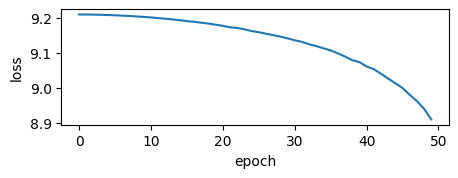

  2%|▏         | 99/5000 [01:32<1:16:14,  1.07it/s]

----
Epoch [100/5000], Loss: 6.5218



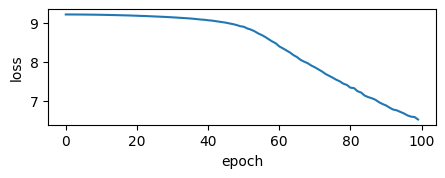

  3%|▎         | 149/5000 [02:19<1:15:50,  1.07it/s]

----
Epoch [150/5000], Loss: 5.5524



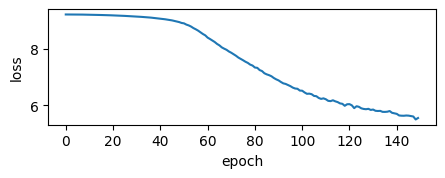

  4%|▍         | 199/5000 [03:07<1:15:33,  1.06it/s]

----
Epoch [200/5000], Loss: 4.7679



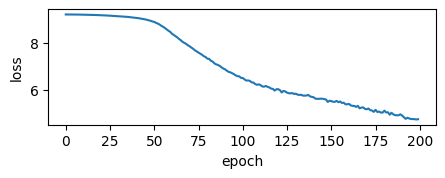

  5%|▍         | 249/5000 [03:54<1:15:02,  1.06it/s]

----
Epoch [250/5000], Loss: 4.1845



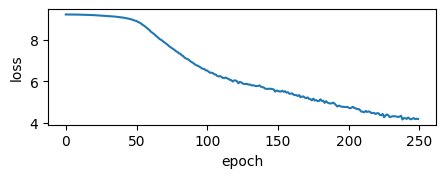

  6%|▌         | 299/5000 [04:42<1:14:24,  1.05it/s]

----
Epoch [300/5000], Loss: 3.8937



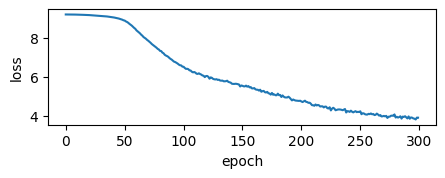

  7%|▋         | 349/5000 [05:30<1:13:27,  1.06it/s]

----
Epoch [350/5000], Loss: 3.5080



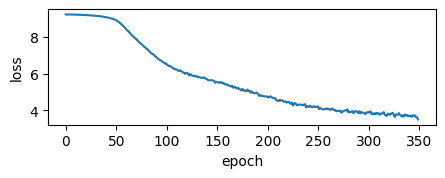

  8%|▊         | 399/5000 [06:17<1:12:29,  1.06it/s]

----
Epoch [400/5000], Loss: 3.4118



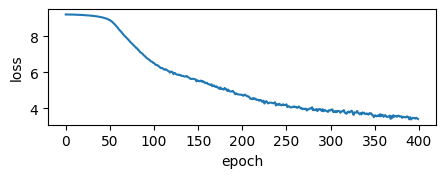

  9%|▉         | 449/5000 [07:05<1:11:52,  1.06it/s]

----
Epoch [450/5000], Loss: 3.2897



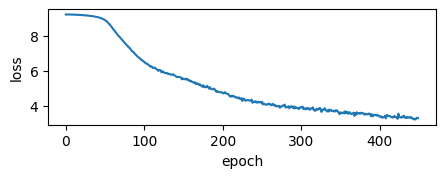

 10%|▉         | 499/5000 [07:52<1:11:14,  1.05it/s]

----
Epoch [500/5000], Loss: 3.1002



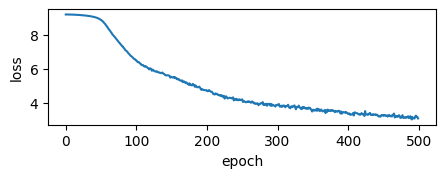

 11%|█         | 549/5000 [08:40<1:10:14,  1.06it/s]

----
Epoch [550/5000], Loss: 3.1162



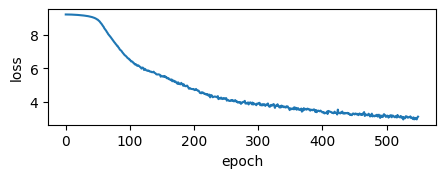

 12%|█▏        | 599/5000 [09:28<1:09:27,  1.06it/s]

----
Epoch [600/5000], Loss: 2.9904



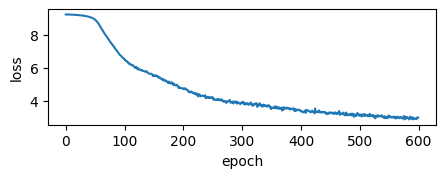

 13%|█▎        | 649/5000 [10:16<1:08:46,  1.05it/s]

----
Epoch [650/5000], Loss: 2.7851



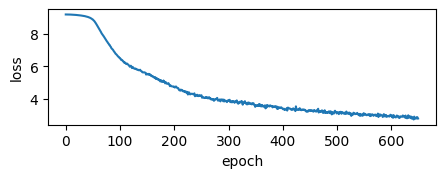

 14%|█▍        | 699/5000 [11:03<1:07:54,  1.06it/s]

----
Epoch [700/5000], Loss: 2.7419



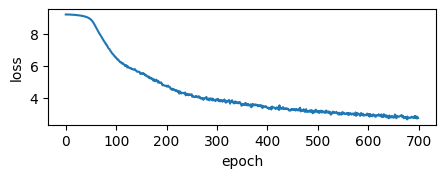

 15%|█▍        | 749/5000 [11:51<1:07:09,  1.06it/s]

----
Epoch [750/5000], Loss: 2.6108



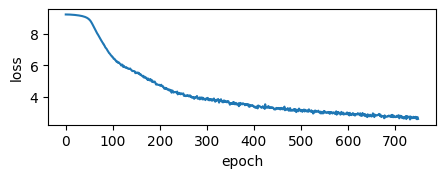

 16%|█▌        | 799/5000 [12:39<1:06:27,  1.05it/s]

----
Epoch [800/5000], Loss: 2.6615



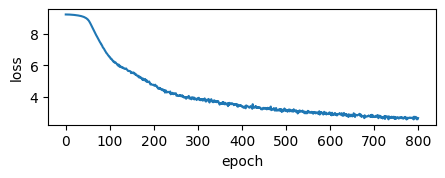

 17%|█▋        | 849/5000 [13:26<1:05:38,  1.05it/s]

----
Epoch [850/5000], Loss: 2.5906



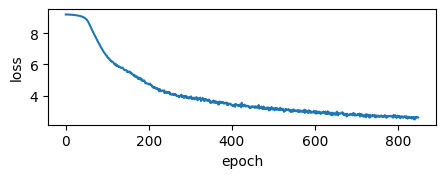

 18%|█▊        | 899/5000 [14:14<1:04:49,  1.05it/s]

----
Epoch [900/5000], Loss: 2.4390



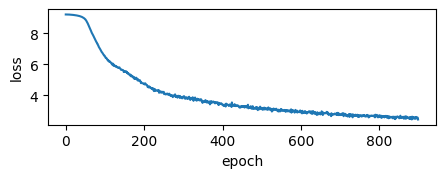

 19%|█▉        | 949/5000 [15:02<1:04:00,  1.05it/s]

----
Epoch [950/5000], Loss: 2.4594



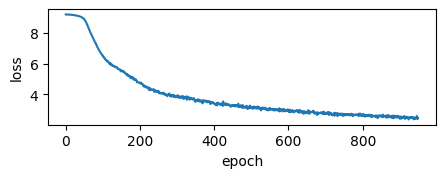

 20%|█▉        | 999/5000 [15:49<1:03:12,  1.05it/s]

----
Epoch [1000/5000], Loss: 2.4654



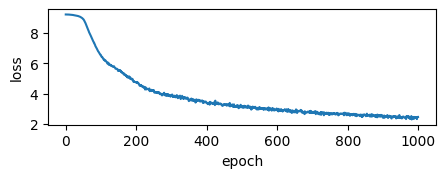

 21%|██        | 1049/5000 [16:37<1:02:23,  1.06it/s]

----
Epoch [1050/5000], Loss: 2.3024



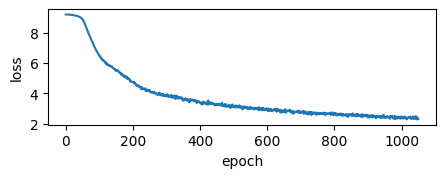

 22%|██▏       | 1099/5000 [17:25<1:01:40,  1.05it/s]

----
Epoch [1100/5000], Loss: 2.3502



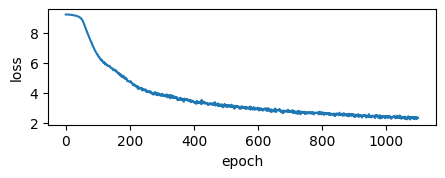

 23%|██▎       | 1149/5000 [18:12<1:00:49,  1.06it/s]

----
Epoch [1150/5000], Loss: 2.3398



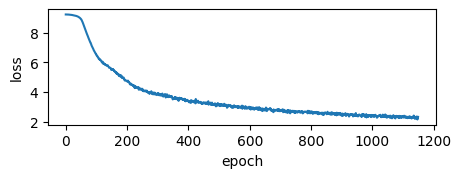

 24%|██▍       | 1199/5000 [19:00<1:00:05,  1.05it/s]

----
Epoch [1200/5000], Loss: 2.2009



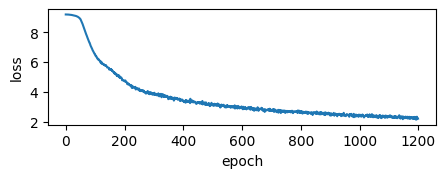

 25%|██▍       | 1249/5000 [19:47<59:15,  1.05it/s]  

----
Epoch [1250/5000], Loss: 2.1499



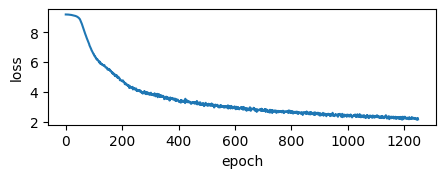

 26%|██▌       | 1299/5000 [20:35<58:41,  1.05it/s]  

----
Epoch [1300/5000], Loss: 2.2211



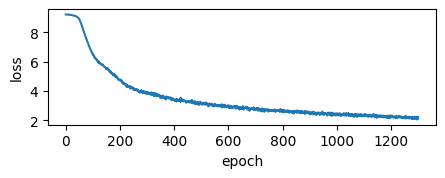

 27%|██▋       | 1349/5000 [21:23<57:42,  1.05it/s]  

----
Epoch [1350/5000], Loss: 2.0821



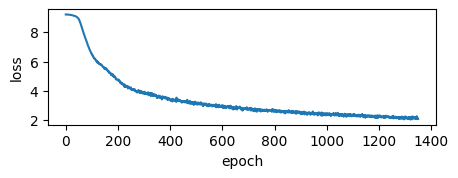

 28%|██▊       | 1399/5000 [22:10<56:52,  1.06it/s]  

----
Epoch [1400/5000], Loss: 2.1632



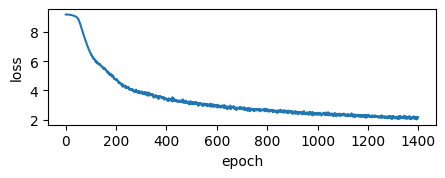

 29%|██▉       | 1449/5000 [22:58<56:04,  1.06it/s]  

----
Epoch [1450/5000], Loss: 2.1087



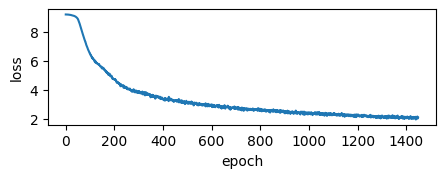

 30%|██▉       | 1499/5000 [23:46<55:20,  1.05it/s]  

----
Epoch [1500/5000], Loss: 2.0461



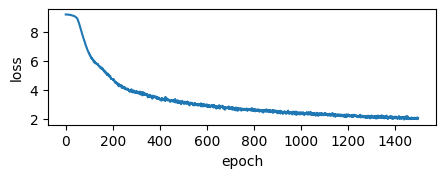

 31%|███       | 1549/5000 [24:33<54:35,  1.05it/s]

----
Epoch [1550/5000], Loss: 2.0187



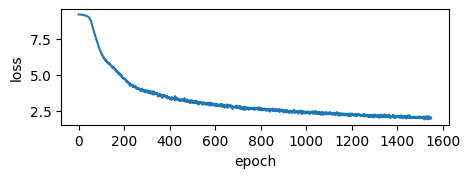

 32%|███▏      | 1599/5000 [25:21<53:43,  1.06it/s]

----
Epoch [1600/5000], Loss: 1.9730



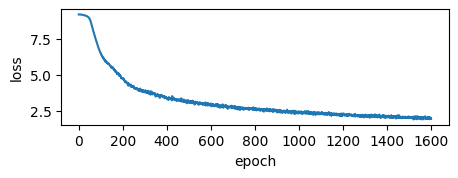

 33%|███▎      | 1649/5000 [26:09<53:02,  1.05it/s]

----
Epoch [1650/5000], Loss: 1.9427



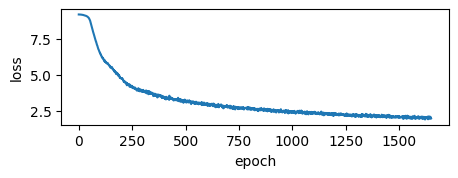

 34%|███▍      | 1699/5000 [26:56<52:11,  1.05it/s]

----
Epoch [1700/5000], Loss: 1.8736



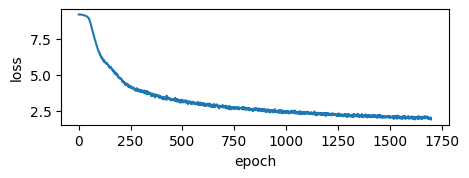

 35%|███▍      | 1749/5000 [27:44<51:20,  1.06it/s]

----
Epoch [1750/5000], Loss: 1.9122



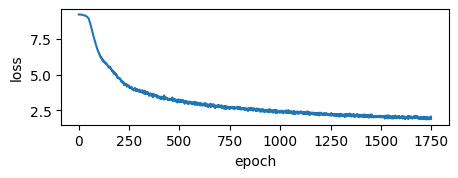

 36%|███▌      | 1799/5000 [28:32<50:43,  1.05it/s]

----
Epoch [1800/5000], Loss: 1.9892



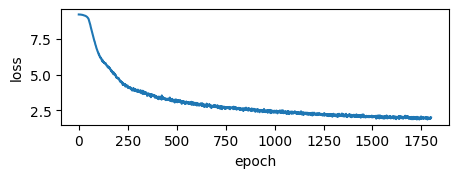

 37%|███▋      | 1849/5000 [29:19<49:50,  1.05it/s]

----
Epoch [1850/5000], Loss: 1.9379



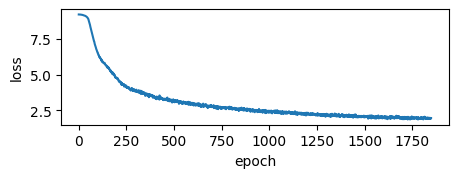

 38%|███▊      | 1899/5000 [30:07<49:01,  1.05it/s]

----
Epoch [1900/5000], Loss: 1.9095



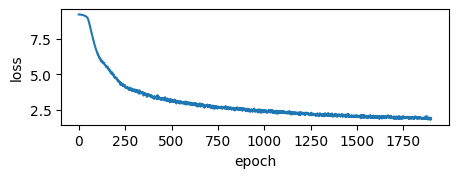

 39%|███▉      | 1949/5000 [30:55<48:13,  1.05it/s]

----
Epoch [1950/5000], Loss: 1.9495



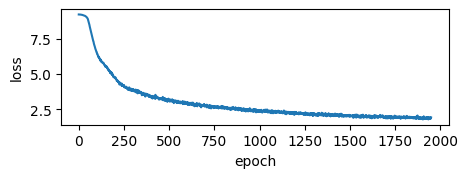

 40%|███▉      | 1999/5000 [31:42<47:21,  1.06it/s]

----
Epoch [2000/5000], Loss: 1.8693



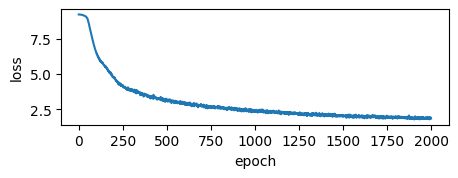

 41%|████      | 2049/5000 [32:30<46:47,  1.05it/s]

----
Epoch [2050/5000], Loss: 1.8553



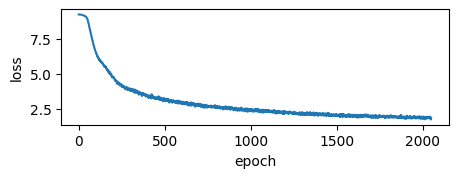

 42%|████▏     | 2099/5000 [33:18<45:49,  1.06it/s]

----
Epoch [2100/5000], Loss: 1.7792



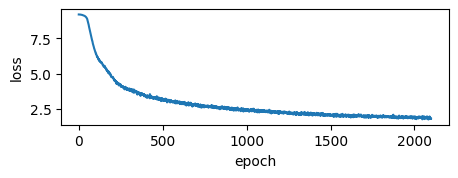

 43%|████▎     | 2149/5000 [34:05<45:04,  1.05it/s]

----
Epoch [2150/5000], Loss: 1.8026



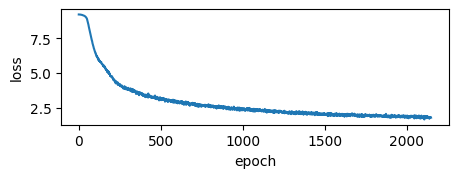

 44%|████▍     | 2199/5000 [34:53<44:14,  1.06it/s]

----
Epoch [2200/5000], Loss: 1.8398



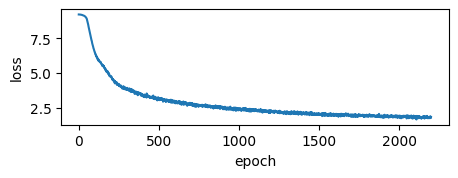

 45%|████▍     | 2249/5000 [35:41<43:24,  1.06it/s]

----
Epoch [2250/5000], Loss: 1.9044



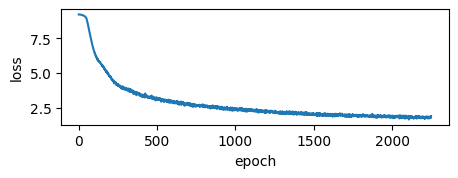

 46%|████▌     | 2299/5000 [36:28<42:46,  1.05it/s]

----
Epoch [2300/5000], Loss: 1.7991



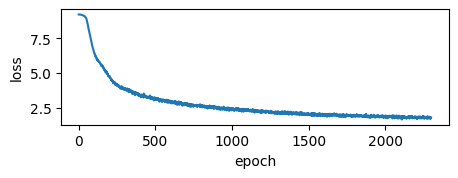

 47%|████▋     | 2349/5000 [37:16<41:57,  1.05it/s]

----
Epoch [2350/5000], Loss: 1.8335



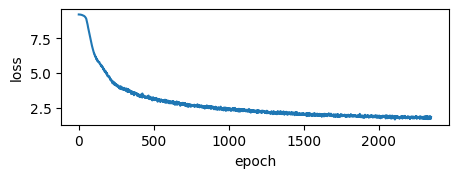

 48%|████▊     | 2399/5000 [38:04<41:10,  1.05it/s]

----
Epoch [2400/5000], Loss: 1.8981



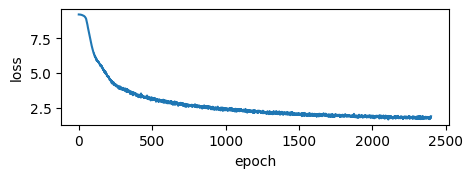

 49%|████▉     | 2449/5000 [38:51<40:23,  1.05it/s]

----
Epoch [2450/5000], Loss: 1.7235



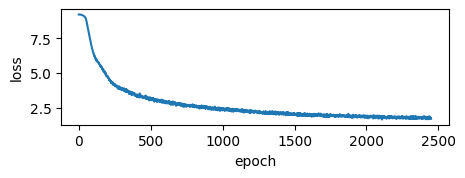

 50%|████▉     | 2499/5000 [39:39<39:31,  1.05it/s]

----
Epoch [2500/5000], Loss: 1.7447



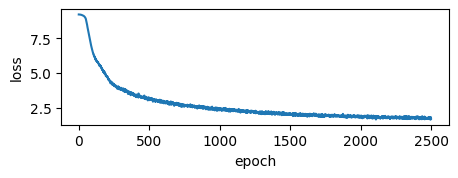

 51%|█████     | 2549/5000 [40:26<38:42,  1.06it/s]

----
Epoch [2550/5000], Loss: 1.7759



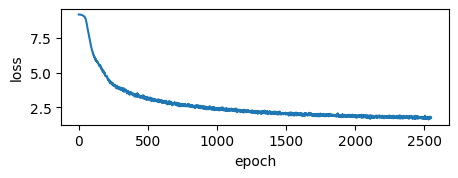

 52%|█████▏    | 2599/5000 [41:14<37:55,  1.06it/s]

----
Epoch [2600/5000], Loss: 1.7724



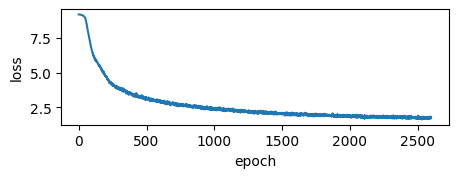

 53%|█████▎    | 2649/5000 [42:02<37:06,  1.06it/s]

----
Epoch [2650/5000], Loss: 1.7266



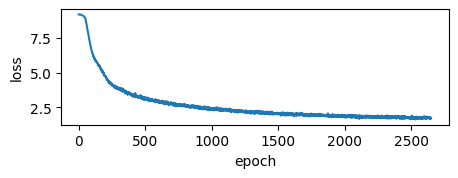

 54%|█████▍    | 2699/5000 [42:49<36:17,  1.06it/s]

----
Epoch [2700/5000], Loss: 1.7723



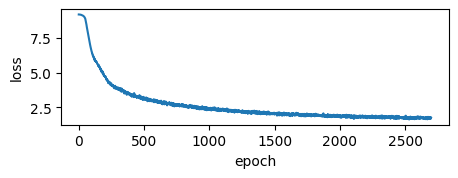

 55%|█████▍    | 2749/5000 [43:37<35:33,  1.06it/s]

----
Epoch [2750/5000], Loss: 1.6756



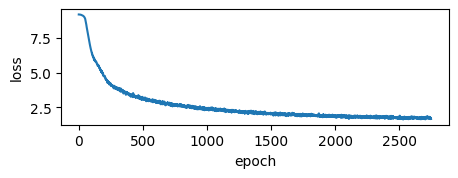

 56%|█████▌    | 2799/5000 [44:25<34:43,  1.06it/s]

----
Epoch [2800/5000], Loss: 1.6951



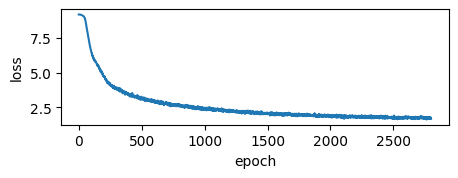

 57%|█████▋    | 2849/5000 [45:12<34:03,  1.05it/s]

----
Epoch [2850/5000], Loss: 1.7008



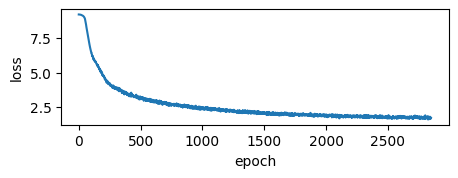

 58%|█████▊    | 2899/5000 [46:00<33:10,  1.06it/s]

----
Epoch [2900/5000], Loss: 1.7062



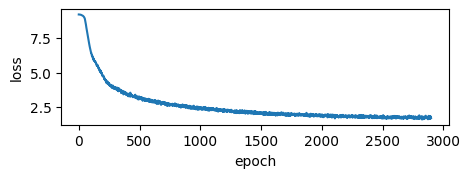

 59%|█████▉    | 2949/5000 [46:48<32:23,  1.06it/s]

----
Epoch [2950/5000], Loss: 1.7270



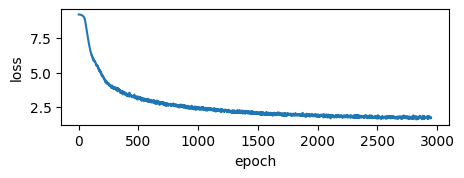

 60%|█████▉    | 2999/5000 [47:35<31:37,  1.05it/s]

----
Epoch [3000/5000], Loss: 1.6938



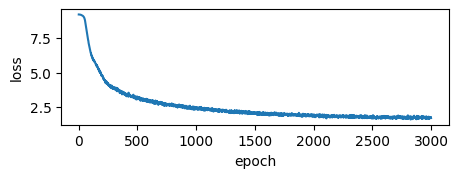

 61%|██████    | 3049/5000 [48:23<30:52,  1.05it/s]

----
Epoch [3050/5000], Loss: 1.7768



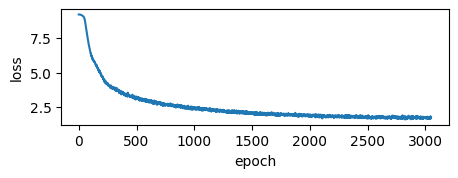

 62%|██████▏   | 3099/5000 [49:11<30:02,  1.05it/s]

----
Epoch [3100/5000], Loss: 1.6631



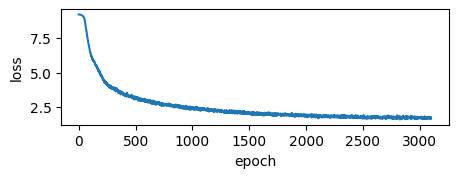

 63%|██████▎   | 3149/5000 [49:58<29:15,  1.05it/s]

----
Epoch [3150/5000], Loss: 1.7402



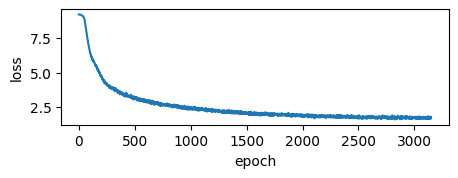

 64%|██████▍   | 3199/5000 [50:46<28:27,  1.05it/s]

----
Epoch [3200/5000], Loss: 1.6301



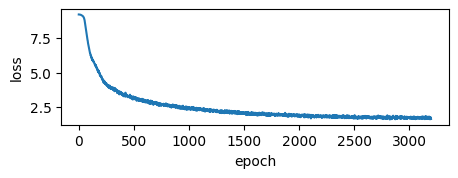

 65%|██████▍   | 3249/5000 [51:34<27:42,  1.05it/s]

----
Epoch [3250/5000], Loss: 1.7881



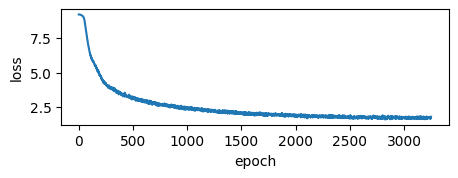

 66%|██████▌   | 3299/5000 [52:21<26:56,  1.05it/s]

----
Epoch [3300/5000], Loss: 1.7780



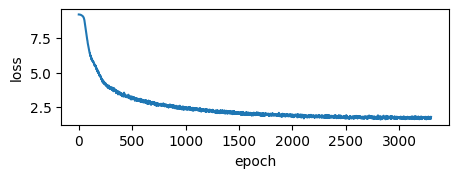

 67%|██████▋   | 3349/5000 [53:09<26:07,  1.05it/s]

----
Epoch [3350/5000], Loss: 1.7215



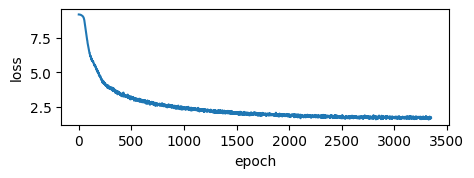

 68%|██████▊   | 3399/5000 [53:57<25:17,  1.06it/s]

----
Epoch [3400/5000], Loss: 1.7013



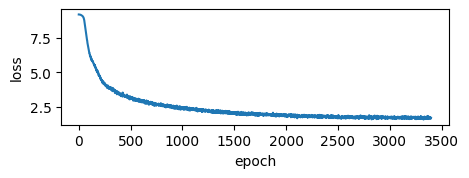

 69%|██████▉   | 3449/5000 [54:44<24:31,  1.05it/s]

----
Epoch [3450/5000], Loss: 1.6787



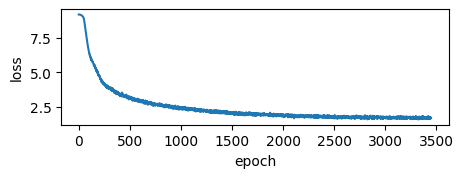

 70%|██████▉   | 3499/5000 [55:32<23:44,  1.05it/s]

----
Epoch [3500/5000], Loss: 1.6581



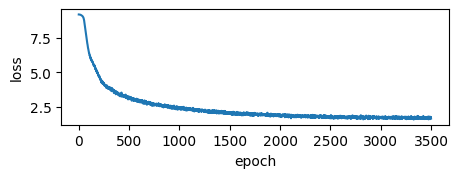

 71%|███████   | 3549/5000 [56:20<22:56,  1.05it/s]

----
Epoch [3550/5000], Loss: 1.6516



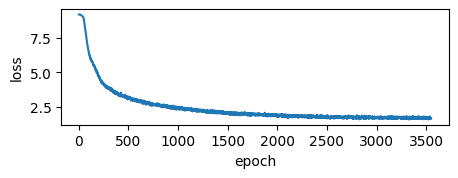

 72%|███████▏  | 3599/5000 [57:07<22:07,  1.06it/s]

----
Epoch [3600/5000], Loss: 1.6763



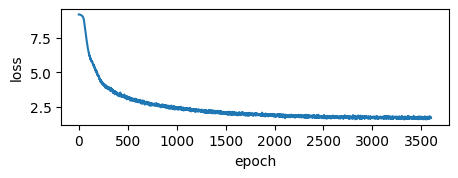

 73%|███████▎  | 3649/5000 [57:55<21:20,  1.06it/s]

----
Epoch [3650/5000], Loss: 1.6601



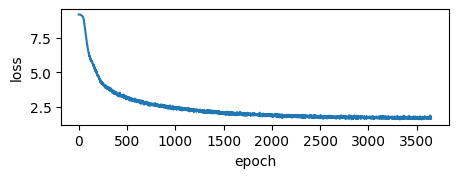

 74%|███████▍  | 3699/5000 [58:43<20:33,  1.05it/s]

----
Epoch [3700/5000], Loss: 1.6612



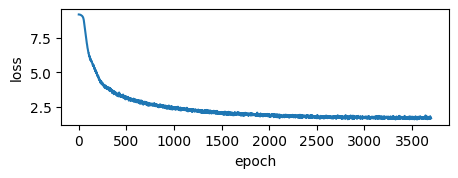

 75%|███████▍  | 3749/5000 [59:30<19:44,  1.06it/s]

----
Epoch [3750/5000], Loss: 1.7166



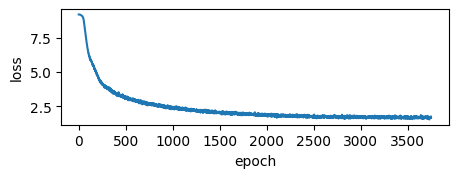

 76%|███████▌  | 3799/5000 [1:00:18<18:55,  1.06it/s]

----
Epoch [3800/5000], Loss: 1.6938



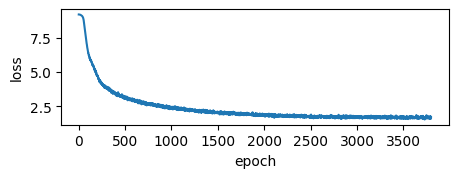

 77%|███████▋  | 3849/5000 [1:01:06<18:10,  1.06it/s]

----
Epoch [3850/5000], Loss: 1.7872



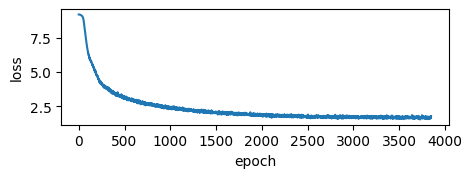

 78%|███████▊  | 3899/5000 [1:01:53<17:23,  1.06it/s]

----
Epoch [3900/5000], Loss: 1.7701



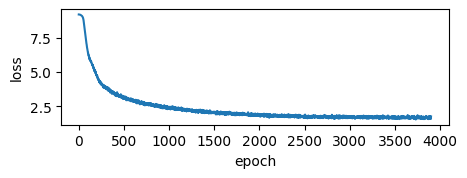

 79%|███████▉  | 3949/5000 [1:02:41<16:38,  1.05it/s]

----
Epoch [3950/5000], Loss: 1.7149



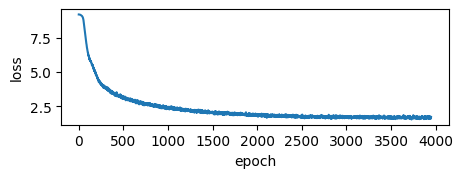

 80%|███████▉  | 3999/5000 [1:03:29<15:50,  1.05it/s]

----
Epoch [4000/5000], Loss: 1.6240



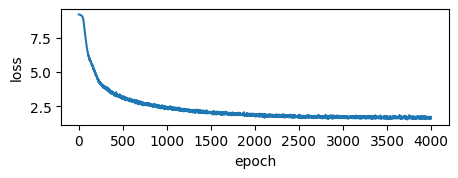

 81%|████████  | 4049/5000 [1:04:16<15:01,  1.05it/s]

----
Epoch [4050/5000], Loss: 1.6612



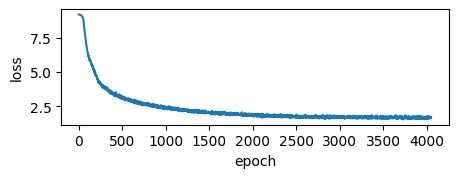

 82%|████████▏ | 4099/5000 [1:05:04<14:13,  1.06it/s]

----
Epoch [4100/5000], Loss: 1.7082



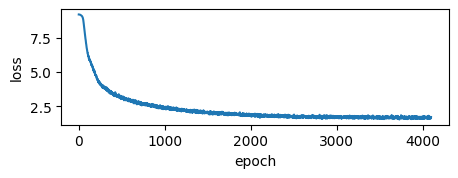

 83%|████████▎ | 4149/5000 [1:05:52<13:26,  1.06it/s]

----
Epoch [4150/5000], Loss: 1.5827



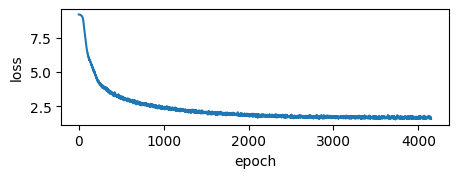

 84%|████████▍ | 4199/5000 [1:06:39<12:38,  1.06it/s]

----
Epoch [4200/5000], Loss: 1.7075



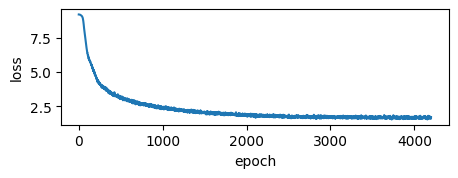

 85%|████████▍ | 4249/5000 [1:07:27<11:52,  1.05it/s]

----
Epoch [4250/5000], Loss: 1.5896



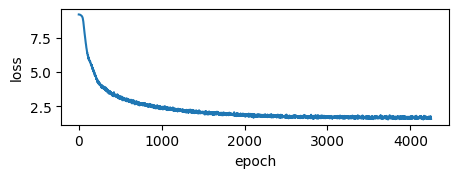

 86%|████████▌ | 4299/5000 [1:08:14<11:04,  1.05it/s]

----
Epoch [4300/5000], Loss: 1.6216



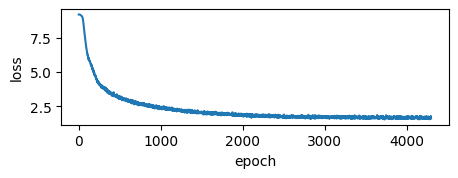

 87%|████████▋ | 4349/5000 [1:09:02<10:18,  1.05it/s]

----
Epoch [4350/5000], Loss: 1.6385



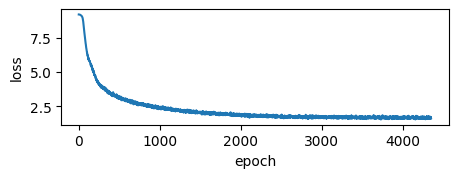

 88%|████████▊ | 4399/5000 [1:09:50<09:29,  1.05it/s]

----
Epoch [4400/5000], Loss: 1.6568



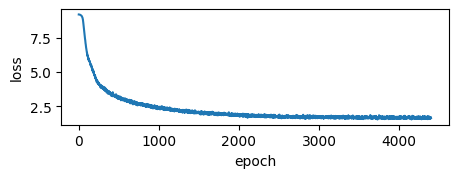

 89%|████████▉ | 4449/5000 [1:10:37<08:42,  1.05it/s]

----
Epoch [4450/5000], Loss: 1.5973



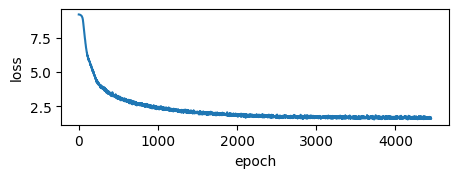

 90%|████████▉ | 4499/5000 [1:11:25<07:54,  1.06it/s]

----
Epoch [4500/5000], Loss: 1.6875



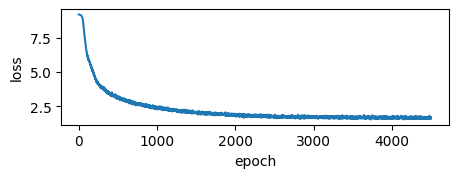

 91%|█████████ | 4549/5000 [1:12:13<07:07,  1.05it/s]

----
Epoch [4550/5000], Loss: 1.7144



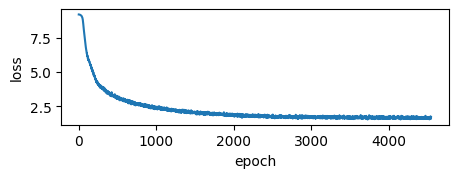

 92%|█████████▏| 4599/5000 [1:13:00<06:20,  1.05it/s]

----
Epoch [4600/5000], Loss: 1.6315



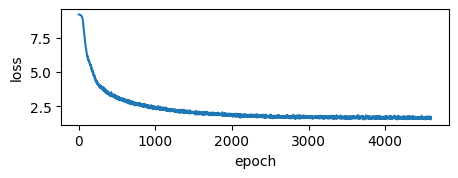

 93%|█████████▎| 4649/5000 [1:13:48<05:32,  1.05it/s]

----
Epoch [4650/5000], Loss: 1.7424



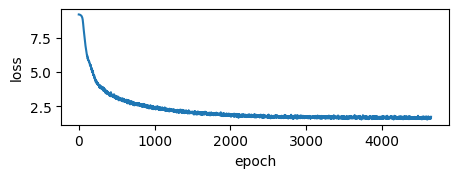

 94%|█████████▍| 4699/5000 [1:14:36<04:46,  1.05it/s]

----
Epoch [4700/5000], Loss: 1.6740



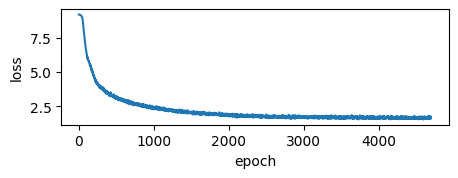

 95%|█████████▍| 4749/5000 [1:15:24<03:57,  1.06it/s]

----
Epoch [4750/5000], Loss: 1.6979



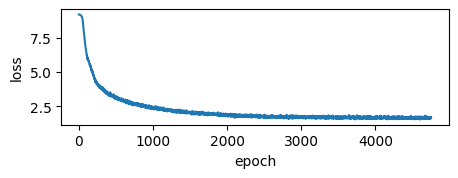

 96%|█████████▌| 4799/5000 [1:16:11<03:10,  1.05it/s]

----
Epoch [4800/5000], Loss: 1.7173



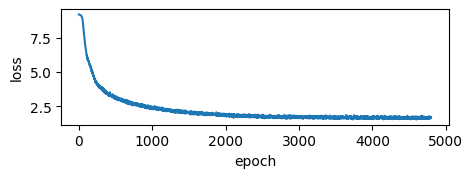

 97%|█████████▋| 4849/5000 [1:16:59<02:23,  1.05it/s]

----
Epoch [4850/5000], Loss: 1.6235



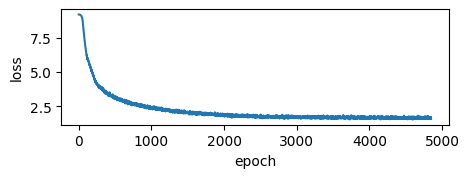

 98%|█████████▊| 4899/5000 [1:17:47<01:35,  1.05it/s]

----
Epoch [4900/5000], Loss: 1.7049



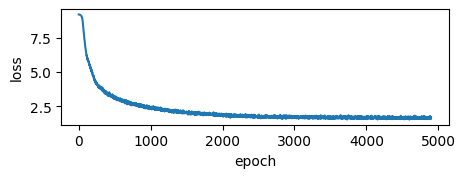

 99%|█████████▉| 4949/5000 [1:18:34<00:48,  1.06it/s]

----
Epoch [4950/5000], Loss: 1.6894



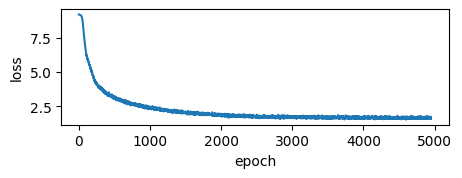

100%|█████████▉| 4999/5000 [1:19:22<00:00,  1.05it/s]

----
Epoch [5000/5000], Loss: 1.6250



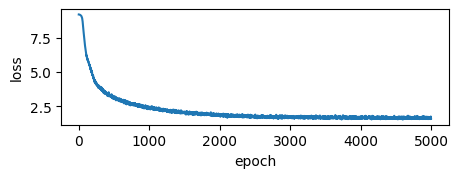

100%|██████████| 5000/5000 [1:19:22<00:00,  1.05it/s]


In [28]:
train(
    model,
    optimizer,
    epochs=5000,
    batch_size=64,
    T_w=1000,
    T_c=3000,
    checkpoint_dir=project_dir / "checkpoints",
    save_every=50,
)